# Australia Housing Price - Regression Analysis & Prediction
# Author: Lu (Christina) Jin

# Setup: Import all libraries

In [150]:
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from pylab import rcParams
rcParams['figure.figsize'] = (20, 10)
sns.set_style('darkgrid')
plt.style.use('seaborn-darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Analysis of Variance test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import f_oneway

# Part A: Regression Analysis

## 1. Introducing Australia current listings analyzation data




> ### 1.1 Acquiring Data and Basic Cleaning
*   Read data from Google Sheet
*   Drop unrelated country column
*   Remove any N/A datapoints


In [33]:
# Read data
data_au_path="https://docs.google.com/spreadsheets/d/e/2PACX-1vQKKR48uSfSS77XnyaRqws4vuGYh7dgBLZp_juzJEZNRnkQ9DiSJcl-MQ8ia5JidNYErAZMXu4Q8FbS/pub?gid=962251625&single=true&output=csv"
listing_df= pd.read_csv(data_au_path, index_col="id")
listing_df

,country,state,neighbourhood_cleansed,property_type,square_meters,price,room_type,bathrooms,bedrooms,beds
id,,,,,,,,,,
3363954,Australia,NSW,BALLINA SHIRE COUNCIL,House,0.00,"$2,900.00",Entire home/apt,3.0,4.0,4.0
13048065,Australia,NSW,BALLINA SHIRE COUNCIL,House,1.55,$28.00,Private room,1.0,1.0,1.0
1451202,Australia,NSW,BALLINA SHIRE COUNCIL,Guest suite,15.00,$141.00,Entire home/apt,1.0,1.0,1.0
2345959,Australia,NSW,BALLINA SHIRE COUNCIL,House,16.58,$50.00,Private room,4.0,4.0,3.0
26087141,Australia,NSW,BALLINA SHIRE COUNCIL,House,16.71,$52.00,Private room,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
23219853,Australia,NSW,TWEED SHIRE COUNCIL,House,62.95,$860.00,Entire home/apt,4.0,6.0,6.0
27612762,Australia,QLD,TWEED SHIRE COUNCIL,Apartment,68.06,$938.00,Entire home/apt,2.0,3.0,3.0
32669144,Australia,NaN,TWEED SHIRE COUNCIL,House,66.00,$886.00,Entire home/apt,2.0,4.0,5.0


In [34]:
# Drop country column since listings are all located in Australia
listing_df = listing_df.drop(columns = ['country'])

# Dro incomplete entries
listing_df = listing_df.dropna()
print(listing_df.describe())
print(listing_df.info())

       square_meters    bathrooms     bedrooms         beds
count    3773.000000  3773.000000  3773.000000  3773.000000
mean       31.839380     1.622582     2.230321     2.934270
std        12.059566     0.838426     1.371662     2.001305
min         0.000000     0.000000     0.000000     0.000000
25%        24.370000     1.000000     1.000000     1.000000
50%        29.330000     1.000000     2.000000     3.000000
75%        34.090000     2.000000     3.000000     4.000000
max       208.700000     9.000000    12.000000    18.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3773 entries, 3363954 to 18182089
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3773 non-null   object 
 1   neighbourhood_cleansed  3773 non-null   object 
 2   property_type           3773 non-null   object 
 3   square_meters           3773 non-null   float64
 4   price                

> ### 1.2 Perform Light Modification
*   Trim outliers
*   Filter dataset to foucs on specific areas with the majority of listings
*   Filter dataset to focus on specific property and room types







In [35]:
# Convert price with dollar sign to integer
listing_df['price'] = listing_df['price'].replace( '[\$,)]','', regex=True ).astype(float)


# Trim outliers:
starting_percentile = listing_df['price'].quantile(.01)
ending_percentile = listing_df['price'].quantile(.99)
listing_price_outliers = listing_df.loc[((listing_df['price'] <= starting_percentile) | 
                                         (listing_df['price'] >= ending_percentile))]
listing_df_trimmed = listing_df.loc[((listing_df['price'] > starting_percentile) & 
                                     (listing_df['price'] < ending_percentile))]
listing_df_trimmed.describe()


,square_meters,price,bathrooms,bedrooms,beds
count,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000
mean,31.803029,761.015160,1.611668,2.221982,2.929074
std,11.924107,732.836937,0.818598,1.356551,1.977494
min,0.000000,53.000000,0.000000,0.000000,0.000000
25%,24.460000,194.000000,1.000000,1.000000,1.000000
50%,29.300000,524.500000,1.000000,2.000000,3.000000
75%,33.840000,1100.000000,2.000000,3.000000,4.000000
max,208.700000,3990.000000,9.000000,12.000000,18.000000


**Explore and filter the data to only include top 80%-85% listings that are located in major neighbourhood areas, and are the most common property/room types**

In [36]:
print(listing_df_trimmed['state'].
      value_counts(normalize=True).round(decimals=2)*100)
print("\n")
print(listing_df_trimmed['neighbourhood_cleansed'].
      value_counts(normalize=True).round(decimals=2)*100)
print("\n")
print(listing_df_trimmed['property_type'].
      value_counts(normalize=True).round(decimals=2)*100)
print("\n")
print(listing_df_trimmed['room_type'].
      value_counts(normalize=True).round(decimals=2)*100)

NSW                95.0
New South Wales     3.0
QLD                 1.0
Nsw                 0.0
nsw                 0.0
Qld                 0.0
queensland          0.0
Queensland          0.0
Name: state, dtype: float64


BYRON SHIRE COUNCIL        65.0
TWEED SHIRE COUNCIL        20.0
BALLINA SHIRE COUNCIL      11.0
LISMORE CITY COUNCIL        3.0
RICHMOND VALLEY COUNCIL     0.0
Name: neighbourhood_cleansed, dtype: float64


House           61.0
Apartment       23.0
Guest suite      7.0
Guesthouse       6.0
Camper/RV        1.0
Nature lodge     1.0
Loft             1.0
Other            1.0
Name: property_type, dtype: float64


Entire home/apt    81.0
Private room       19.0
Shared room         0.0
Name: room_type, dtype: float64


In [37]:
# Drop the state column since 99% of the data are in New South Wales (NSW) state, so it's not informative
listing_df_trimmed = listing_df.drop(columns = ['state'])

In [38]:
# perform filter
listing_df_filtered = listing_df_trimmed.loc[((listing_df_trimmed['neighbourhood_cleansed'] == 'BYRON SHIRE COUNCIL') | (listing_df_trimmed['neighbourhood_cleansed'] == 'TWEED SHIRE COUNCIL'))]
listing_df_filtered = listing_df_filtered.loc[((listing_df_trimmed['property_type']=='House') | (listing_df_trimmed['property_type']=='Apartment'))]
listing_df_filtered = listing_df_filtered.loc[(listing_df_trimmed['room_type'].isin(['Entire home/apt']))]

listing_df_filtered

,neighbourhood_cleansed,property_type,square_meters,price,room_type,bathrooms,bedrooms,beds
id,,,,,,,,
33699975,BYRON SHIRE COUNCIL,House,4.00,1550.0,Entire home/apt,2.0,3.0,3.0
22003381,BYRON SHIRE COUNCIL,Apartment,20.56,99.0,Entire home/apt,0.5,0.0,1.0
24679805,BYRON SHIRE COUNCIL,Apartment,20.36,99.0,Entire home/apt,1.0,1.0,1.0
30136403,BYRON SHIRE COUNCIL,Apartment,19.96,99.0,Entire home/apt,1.0,1.0,1.0
23906053,BYRON SHIRE COUNCIL,House,19.68,85.0,Entire home/apt,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
5719914,TWEED SHIRE COUNCIL,Apartment,62.83,796.0,Entire home/apt,1.0,2.0,4.0
23219853,TWEED SHIRE COUNCIL,House,62.95,860.0,Entire home/apt,4.0,6.0,6.0
27612762,TWEED SHIRE COUNCIL,Apartment,68.06,938.0,Entire home/apt,2.0,3.0,3.0


> ### 1.3 Data Interpretation

In [39]:
# Explore all the varaibles
list(listing_df_filtered)

['neighbourhood_cleansed',
 'property_type',
 'square_meters',
 'price',
 'room_type',
 'bathrooms',
 'bedrooms',
 'beds']

In [40]:
# Describe quantitative variables
listing_df_filtered.describe().round(decimals=2)

,square_meters,price,bathrooms,bedrooms,beds
count,2183.00,2183.00,2183.00,2183.00,2183.00
mean,34.09,1091.20,1.89,2.81,3.69
std,11.08,950.52,0.87,1.27,1.95
min,3.41,1.00,0.00,0.00,0.00
25%,27.84,440.00,1.00,2.00,2.00
50%,30.97,825.00,2.00,3.00,3.00
75%,34.83,1499.00,2.00,4.00,5.00
max,77.00,11500.00,9.00,12.00,18.00


In [41]:
# Describe qualitative variables
listing_df_filtered[['neighbourhood_cleansed','property_type','room_type']].describe()

,neighbourhood_cleansed,property_type,room_type
count,2183,2183,2183
unique,2,2,1
top,BYRON SHIRE COUNCIL,House,Entire home/apt
freq,1649,1496,2183


> #### **Dataset Information:**

This set of data, after cleaning and filtration, contains information and prices of almost 2200 rental listings located in two major areas in Australia. This dataset could be used to analyze and further predict prices for vaction rentals within those areas.



> #### **Variables Interpretation:**

* Neighbourhood_cleansed: neighborhood area names (modified to only have Byron Shire Council and Tweed Shire Council).
* Property_type: Types of properties that are included in the data set (modified to only have house and apartment).
* Square_meters: Size of the rental space within the listing.
* Price: Nightly price of the rental in USD.
* Room_type: Types of rooms available for rental (modified to only have Entire home/apt).
* Bathrooms: Number of bathrooms available in the rental space.
* Bedrooms: Number of bedrooms available in the rental space.
* Beds: Number of beds available in the rental space.





## 2. EDA & Regression Approach 


> ### 2.1 Explore Correlationship Between Multivariates
Observations:
*   It does not look like the number of bathrooms, bedrooms or beds have an obvious impact on the price.
*   There are two strong and independent correlation patterns between price and square meter. Seemingly, some other qualitative factors are influencing the price.
*   Neighborhood areas and property types are two variates that are strongly affecting the price. Second level analysis is needed.
*   Rentals in Byron Shire Council are suprisingly higher in price than those in Tweed Shire Council 
*   Compare to apartments, houses have higher rental price in most cases --- which makes sense.




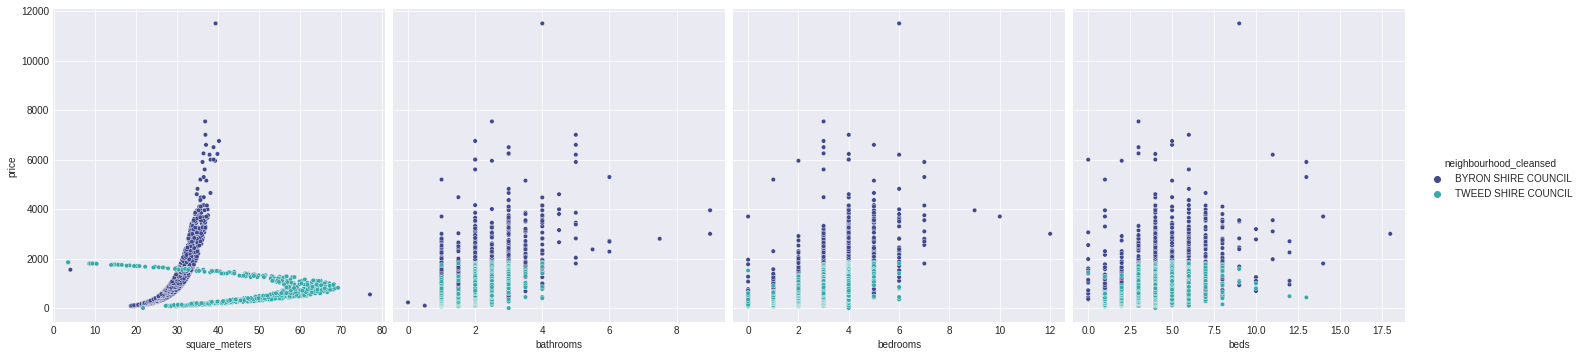

In [42]:
# explore correlationship between price and quantitative variables.
# color coded based on neighbourhood areas
sns.pairplot(listing_df_filtered, hue='neighbourhood_cleansed', 
             x_vars=['square_meters','bathrooms','bedrooms','beds'], 
             y_vars=['price'], plot_kws={"s": 20}, palette="mako", height=5)

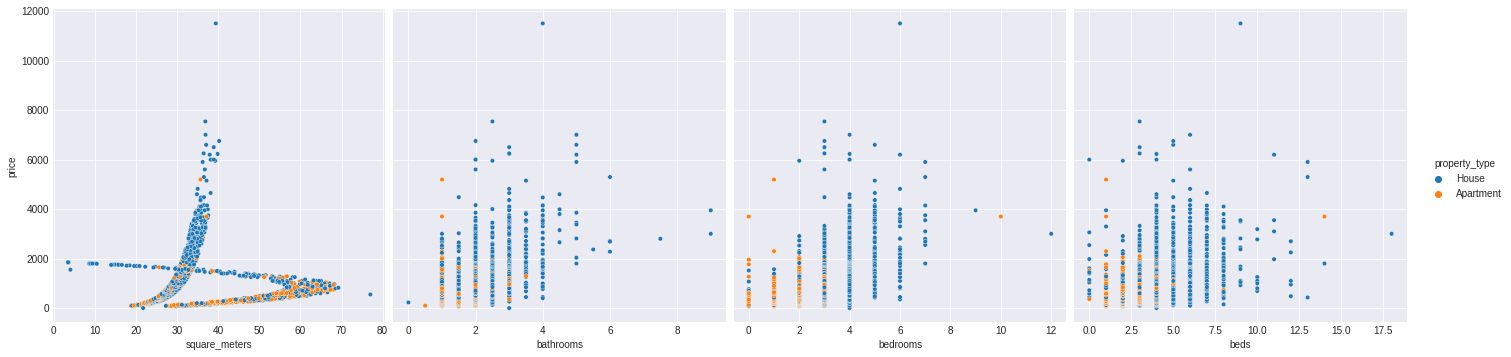

In [43]:
# explore correlationship between price and quantitative variables.
# color coded based on property types
sns.pairplot(listing_df_filtered, hue='property_type', 
             x_vars=['square_meters','bathrooms','bedrooms','beds'], 
             y_vars=['price'], plot_kws={"s": 20}, height=5)

**Since strong correlation has been shown between price and both neighborhood and property types. Second level manipulation will be applied toward this dataset to allow focusing on each specific catagories. The manipulation will process the dataset into 4 groups based on the controlled variate: Byron Shire Council only, Tweed Shire Council only, houses only, and apartments only.**

In [44]:
listing_df_byron = listing_df_filtered.loc[(listing_df_filtered['neighbourhood_cleansed'] == 'BYRON SHIRE COUNCIL')]
listing_df_tweed = listing_df_filtered.loc[(listing_df_filtered['neighbourhood_cleansed'] == 'TWEED SHIRE COUNCIL')]
listing_df_house = listing_df_filtered.loc[(listing_df_filtered['property_type'] == 'House')]
listing_df_apt = listing_df_filtered.loc[(listing_df_filtered['property_type'] == 'Apartment')]

> ### 2.2 Regression Approach

> #### **Scatter plot of price vs sqft within Byron Shire Council only**



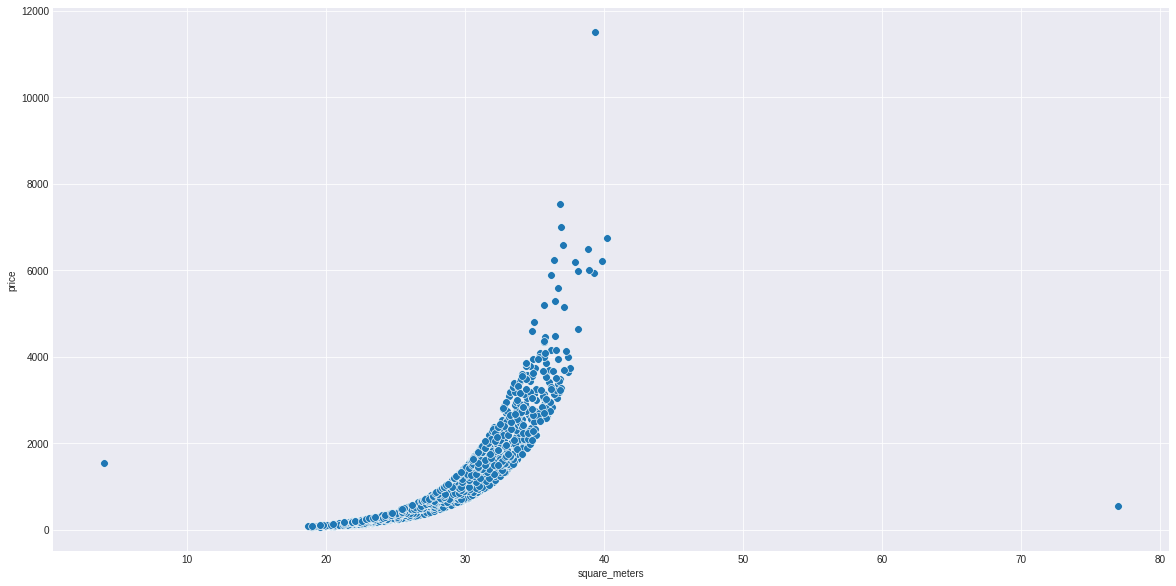

In [45]:
ax_byron = sns.scatterplot(x = 'square_meters', y = 'price', data = listing_df_byron, s=60)

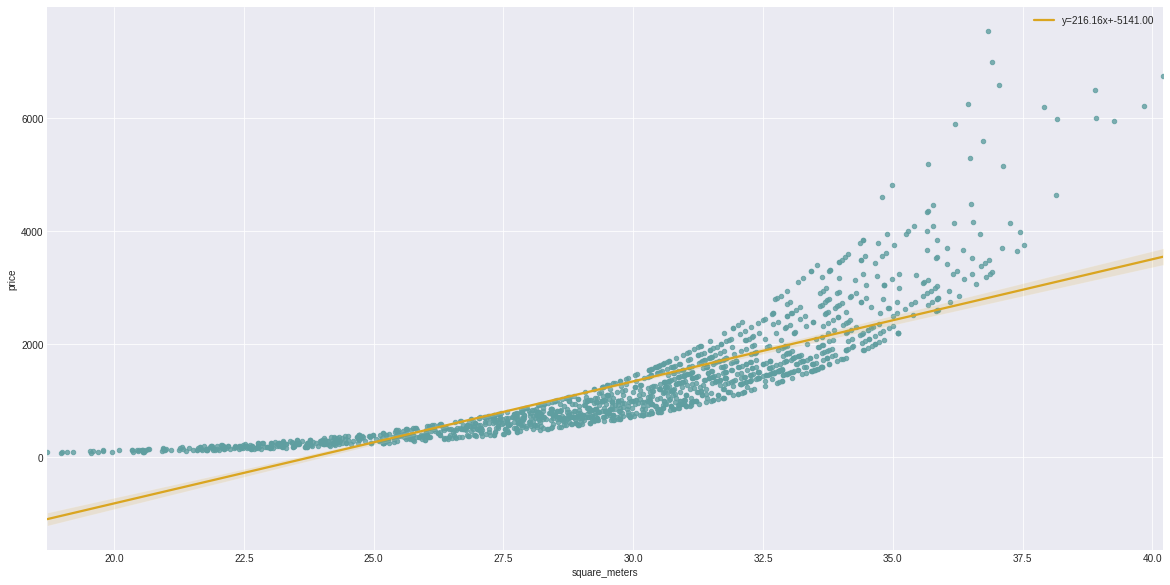

In [46]:
# Trim some outliers and fit a regression line to the plot

listing_df_byron = listing_df_byron[(listing_df_byron["square_meters"]>15)&
                                    (listing_df_byron["square_meters"]<50)&
                                    (listing_df_byron["price"]<8000)]
slope, intercept, r_value, p_value, std_err = stats.linregress(listing_df_byron['square_meters'],
                                                               listing_df_byron['price'])
ax_byron = sns.regplot(x = 'square_meters', y = 'price', data = listing_df_byron,
                       scatter_kws={"color":"cadetblue","s":20}, 
                       line_kws={"color":"goldenrod", 'label':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})
ax_byron.legend()

> #### **Scatter plot of price vs sqft within Tweed Shire Council only**



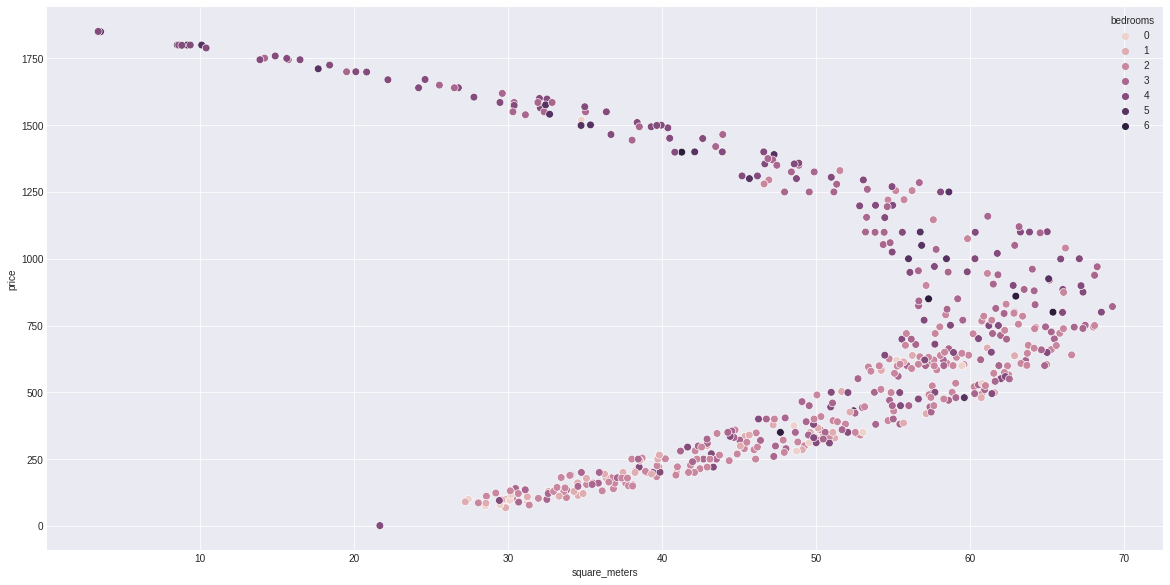

In [47]:
ax_tweed = sns.scatterplot(x = 'square_meters', y = 'price', hue='bedrooms', data = listing_df_tweed, s=60)

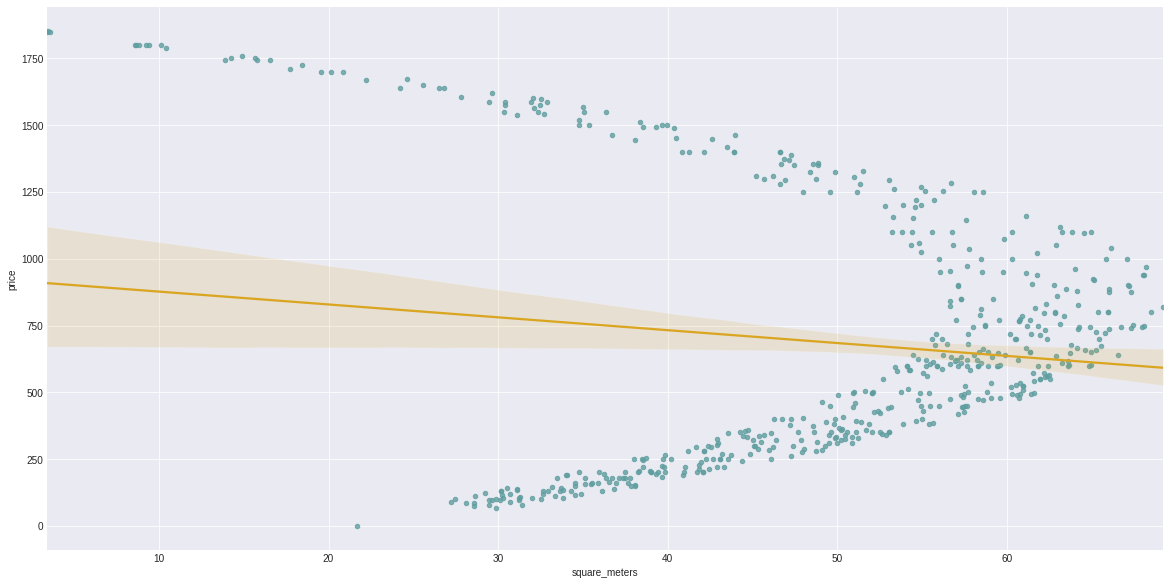

In [48]:
# Fit a regression line to the plot

ax_tweed = sns.regplot(x = 'square_meters', y = 'price', data = listing_df_tweed,
                       scatter_kws={"color":"cadetblue","s":20}, line_kws={"color":"goldenrod"})

## 3. Regression Analysis and Prediction

> ### 3.1 Fit a line with Sci-Kit Learn


**We are going to focusing on fittng a regression model with the rentals in Byron Shire Council area only**

In [49]:
X_cols = ['square_meters']

#Load the X data set
X = listing_df_byron[X_cols].values

#Initialize the data and column length variables
data_length = len(listing_df_byron)
column_length = len(listing_df_byron[X_cols].columns)

#Reshape and load remaining data sets
X = X.reshape(data_length,column_length)
y = listing_df_byron['price'].values
y = y.reshape(data_length,1)

#Split the data into training and testing sets @ random state 10000
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

#Create the linear regression object and train/fit models
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Make predictions using the testing set
listing_y_pred = lin_reg.predict(X_test)

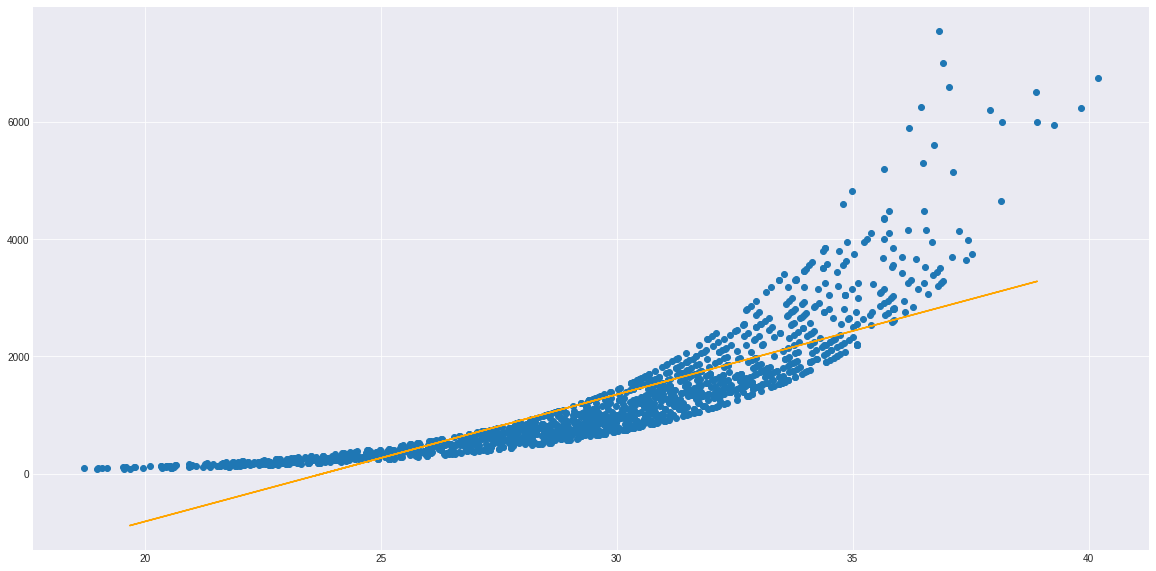

In [50]:
plt.scatter(X,y);
plt.plot(X_test, listing_y_pred, c='orange', linestyle = "-")

In [51]:
#Print a few predictions
print((pd.DataFrame(listing_y_pred, columns={'y_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(lin_reg.intercept_))

#Print the coefficient(s)
print('Coefficient:', float(lin_reg.coef_))
print()

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_pred))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_pred))

   y_prediction
0    -43.227775
1   2111.588033
2   2724.465293
3   1202.017541
4   2202.545082

Intercept: -5147.650748446801
Coefficient: 216.5644027825621

Mean Squared Error (MSE):273872.19
Variance Score (R^2):0.70


**The MSE and Variance Score above shows that even with the trained linear model, it still does not seem to represent the data very well.**

**The data points looks more likely to form a two degree polynomial shape, thus next I will try fit transform the data to a polynomial model and see what performance result it gives us**

> ### 3.2 Fit a curved line with Sci-Kit Learn
**Comparing to the linear model, the performance of the new polynomial model has been improved both visually and numerically.**
* Visually, the curved line seems like a much better fit to the data points given.
* The variance score has been increased to 0.89 instead of 0.73. 
* In terms of MSE value, although it is still quite high, but it has been reduced by half comparing to the model before. 


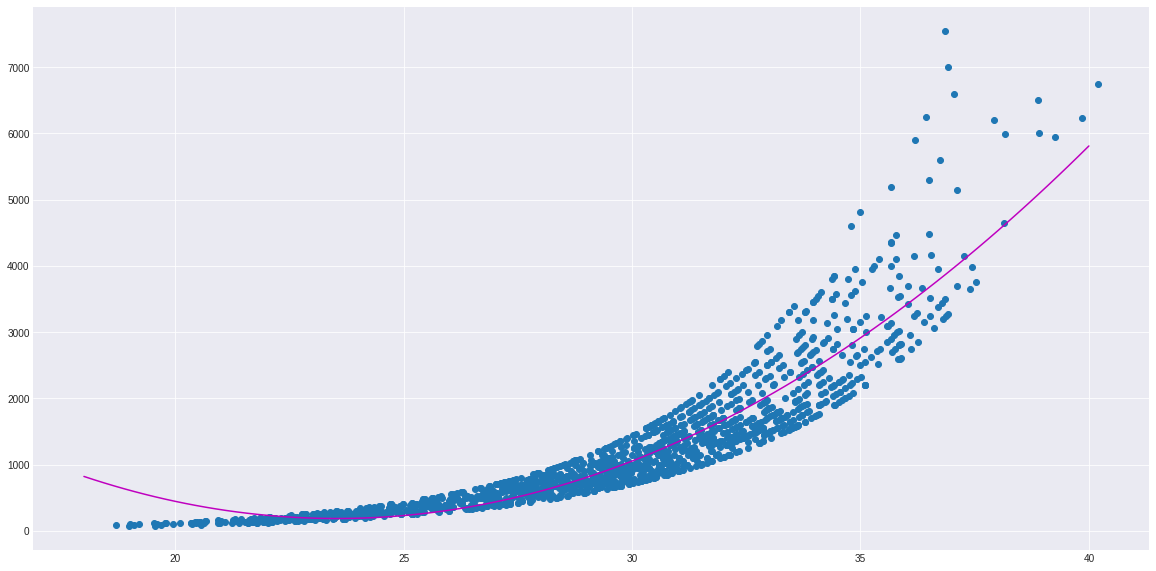

In [52]:
x =  listing_df_byron['square_meters'].values
y = listing_df_byron['price'].values

#Split the data into training and testing sets @ random state 10000
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=1)

#poly_reg.fit(x_train.re, y_train)

poly_fit = np.poly1d(np.polyfit(x_train,y_train,2))
sp = np.linspace(18,40,100)
plt.scatter(X,y)
plt.plot(sp, poly_fit(sp), c='m',linestyle="-")

In [56]:
# Fit transform the data to give us the polynomial featuress
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

#Split the data into training and testing sets @ random state 10000
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly,y, random_state=1)

# Create the 2nd linear regression object and train/fit models
poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_train)

# Make predictions using the testing set
listing_y_polypred = poly_reg.predict(X_poly_test)


In [57]:
#Print a few predictions
print((pd.DataFrame(listing_y_polypred, columns={'y_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(poly_reg.intercept_))
print()

#Print the coefficient(s)
coeff_df = pd.DataFrame(poly_reg.coef_)
coeff_df.columns = X_cols
print(coeff_df)
print()

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_polypred))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_polypred))

   y_prediction
0    185.944488
1   2254.699008
2   3593.336649
3    880.500602
4   2432.369518

Intercept: 11674.122059991245

   square_meters
0       0.000000
1    -976.330838
2      20.743490

Mean Squared Error (MSE):137703.91
Variance Score (R^2):0.85


> ### 3.3 Using Sci-Kit Learn with multiple variables

In [93]:
X_cols2 = ['square_meters', 'bedrooms', 'beds']

#Load the X data set
X2 = listing_df_byron[X_cols2].values

#Initialize the data and column length variables
data_length2 = len(listing_df_byron)
column_length2 = len(listing_df_byron[X_cols2].columns)

#Reshape and load remaining data sets
X2 = X2.reshape(data_length2,column_length2)
y2 = listing_df_byron['price'].values
y2 = y2.reshape(data_length2,1)

#Split the data into training and testing sets @ random state 10000
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, random_state=1)

#Create the linear regression object and train/fit models
lin_reg2 = LinearRegression()
lin_reg2.fit(X_train2, y_train2)

#Make predictions using the testing set
listing_y_pred2 = lin_reg2.predict(X_test2)

In [109]:
#Print a few predictions
print((pd.DataFrame(listing_y_pred2, columns={'y_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(lin_reg2.intercept_))

#Print the coefficient(s)
coeff_df2 = pd.DataFrame(lin_reg2.coef_)
coeff_df2.columns = X_cols2
print(coeff_df2)
print()

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test2, listing_y_pred2))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y_test2, listing_y_pred2))

   y_prediction
0   -106.416474
1   2151.653828
2   2775.267713
3   1218.055157
4   2316.150291

Intercept: -4908.626131138997
   square_meters   bedrooms       beds
0     200.333183  68.513752  11.842774

Mean Squared Error (MSE):271402.86
Variance Score (R^2):0.70


> ### 3.3 Inferences and Predictions

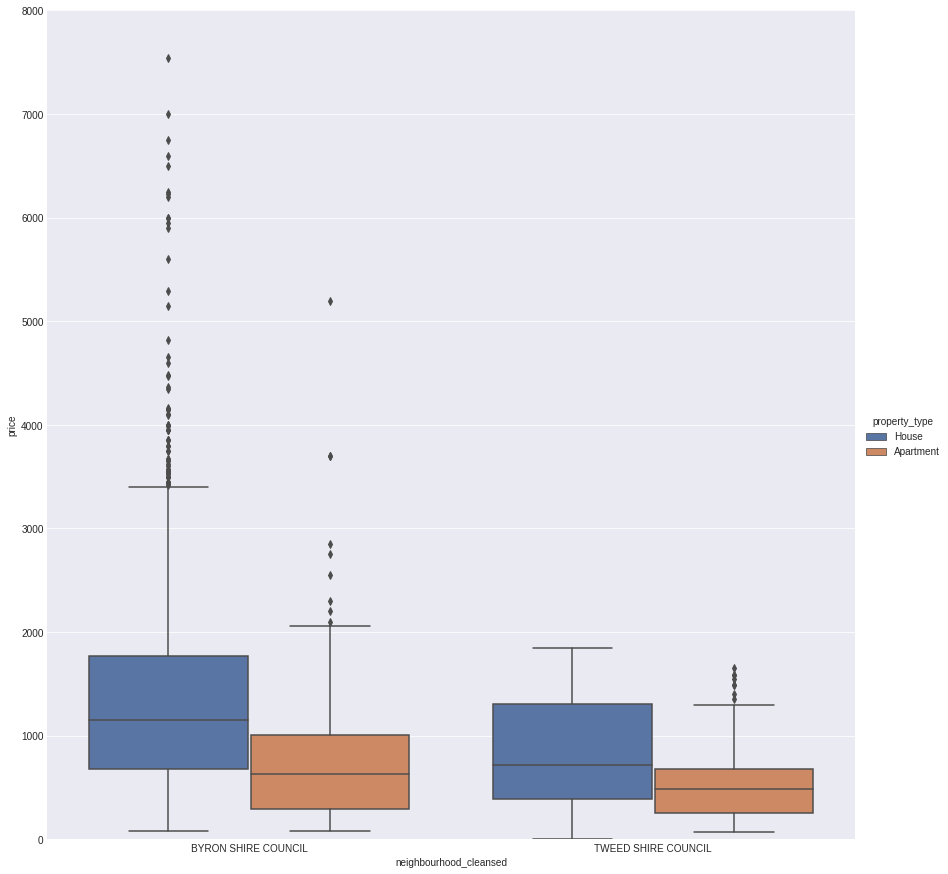

In [443]:
sns.catplot(x="neighbourhood_cleansed", y="price", data=listing_df_filtered, hue="property_type", 
            kind="box", height=12, palette="deep").set(ylim=(0,8000))

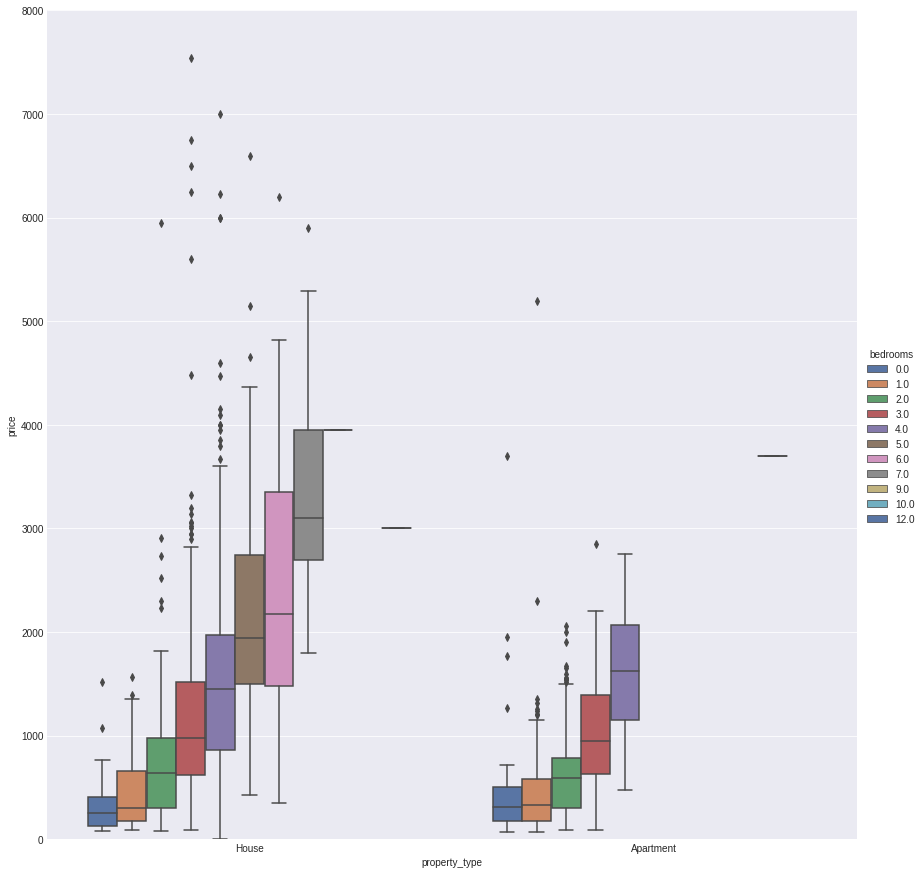

In [450]:
sns.catplot(x="property_type", y="price", data=listing_df_filtered, hue="bedrooms", 
            kind="box", height=12, palette="deep").set(ylim=(0,8000))

**Inferences:**
* Rentals in Byron Shire Council are highly likely to have a much higher price than the ones in Tweed Shire Council, no matter what type of property is it. 
* If someone if trying to find a place with 5 bedrooms or less, they may be better off by looking at apartments rather than houses, since houses are generally priced higher in both areas.
* Another thing that I've noticed with the dataset and think might be noteworthy: Acoording to the scatter plots in last section, there might be some data points that have incorrect rental space area (square meter)recorded. Since there are decent amount of rentals that have very low in square meter values but with very high price. This could due to putting extra "0"(s) in the end when taking down the square meter values or prices.

**I would be comfortable providing pricing recommendations for rentals in Byron Shire Council with given square meters of the space. Even more precise price recommendation could be provided if number of bedrooms and beds are given too.**

**For example, if it was given that a 35-sqm rental house with 3 bedrooms and 4 beds located in Byron Shire, a price recommendation would be as follows:**



In [123]:
area = 35
bedroom = 3
bed = 4

coef1 = 200.333183
coef2 = 68.513752
coef3 = 11.842774

predict_price = coef1*area + coef2*bedroom + coef3*bed
print('For a 35-sqm 3-bedrooms 4-beds house located in Byron Shire, \n the recommended rental price is %.2f' % predict_price + 'dollars')

For a 35-sqm 3-bedrooms 4-beds house located in Byron Shire, 
 the recommended rental price is 7264.57dollars


**It would be hard for to provide pricing predictions/recommendations for rentals in Tweed Shire Council.**